In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
(X_train, _), (_,_) = mnist.load_data()

In [3]:
print(X_train.shape)

(60000, 28, 28)


In [4]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_train.shape

(60000, 784)

In [5]:
# Normalize to [-1,1]
X_train = (X_train.astype('float32') - 127.5) / 127.5
print(X_train.min(), X_train.max())

-1.0 1.0


In [0]:
NOISE_DIM = 32

In [0]:
adam = Adam(lr=0.0002, beta_1=0.5)

In [14]:
generator = Sequential()
generator.add(Dense(128, input_shape=(NOISE_DIM,)))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dense(256))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dense(512))
generator.add(LeakyReLU(alpha=0.2))
generator.add(Dense(784, activation='tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               4224      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 784)               402192    
Total para

In [15]:
discriminator = Sequential()
discriminator.add(Dense(512, input_shape=(784,)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(256))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(64))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 64)                16448     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 64)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 65        
Total para

In [16]:
# Generative Adversial Network (GAN)
discriminator.trainable = False
gan_input = Input(shape=(NOISE_DIM,))
generator_output = generator(gan_input)
gan_output = discriminator(generator_output)

gan = Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=adam)

gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 784)               571024    
_________________________________________________________________
sequential_4 (Sequential)    (None, 1)                 549761    
Total params: 1,120,785
Trainable params: 571,024
Non-trainable params: 549,761
_________________________________________________________________


In [0]:
def plot_images(epoch):
    noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
    generated_imgs = generator.predict(noise)
    generated_imgs = generated_imgs.reshape((-1,28,28))
    
    #Display the Images
    plt.figure(figsize=(10,10))
    for i in range(100):
        plt.subplot(10, 10, i+1)
        plt.imshow(generated_imgs[i], cmap='gray', interpolation='nearest')
        plt.axis("off")
    plt.tight_layout()
    plt.show()
#     plt.savefig("images/gan_output_{0}.png".format(epoch))


In [0]:
def train(epochs=1, batch_size=128):
    plot_images(0)
    for epoch in range(1, epochs+1):
        b = 0
        generator_loss = 0
        discriminator_loss = 0
        
        while b < X_train.shape[0]:
            real_batch = X_train[b:b+batch_size]
            if real_batch.shape[0] < batch_size:
                break
                
            noise = np.random.normal(0, 1, size=(batch_size, NOISE_DIM))
            fake_batch = generator.predict(noise)
#             print(real_batch.shape, random_batch.shape)
            
            # Create input for discriminator
            x_disc = np.concatenate([real_batch, fake_batch])
            y_disc = np.zeros((2*batch_size,))
            y_disc[:batch_size] = 0.9 # Label Smoothing
#             print(x_disc.shape, y_disc.shape)
            
            # Training Discriminator
            discriminator.trainable = True
#             generator.trainable = False
            discriminator_loss += discriminator.train_on_batch(x_disc, y_disc)
#             discriminator_loss += discriminator.train_on_batch(x_batch, np.ones(half_batch)*0.9)
#             discriminator_loss += discriminator.train_on_batch(gen)
            
            # Training Generator
            discriminator.trainable = False
#             generator.trainable = True
            x_gen = np.random.normal(0, 1, size=(batch_size, NOISE_DIM))
            y_gen = np.ones((batch_size,))
#             print(x_gen.shape, y_gen.shape)
            generator_loss += gan.train_on_batch(x_gen, y_gen)
            
            b += batch_size
            
        print("Epoch %d \nDiscriminator Loss %.4f \nGenerator loss %0.4f "%((epoch), discriminator_loss, generator_loss))
        
        if epoch % 5 == 0:
            plot_images(epoch)

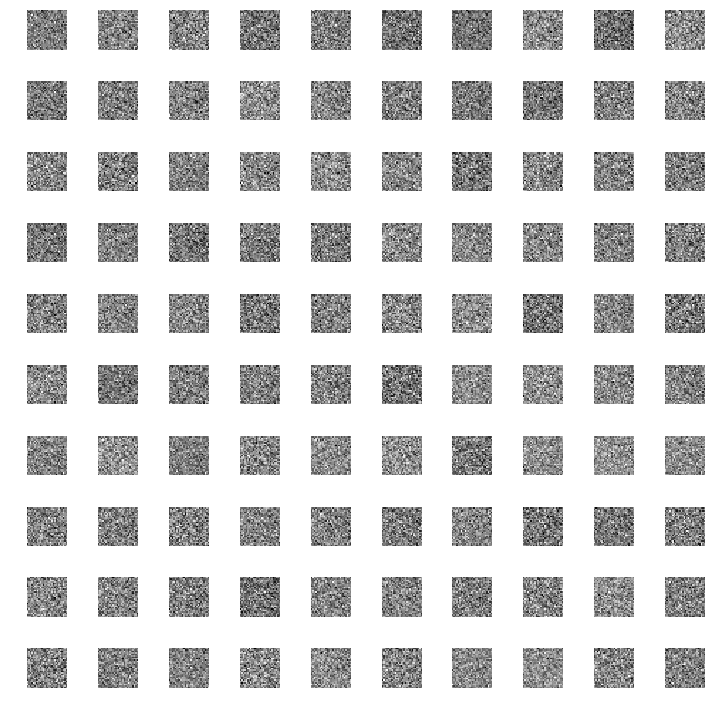

Epoch 1 
Discriminator Loss 273.6532 
Generator loss 618.7029 
Epoch 2 
Discriminator Loss 230.9566 
Generator loss 795.5741 
Epoch 3 
Discriminator Loss 211.4882 
Generator loss 911.2383 
Epoch 4 
Discriminator Loss 204.1960 
Generator loss 939.3081 
Epoch 5 
Discriminator Loss 186.3441 
Generator loss 1036.8045 


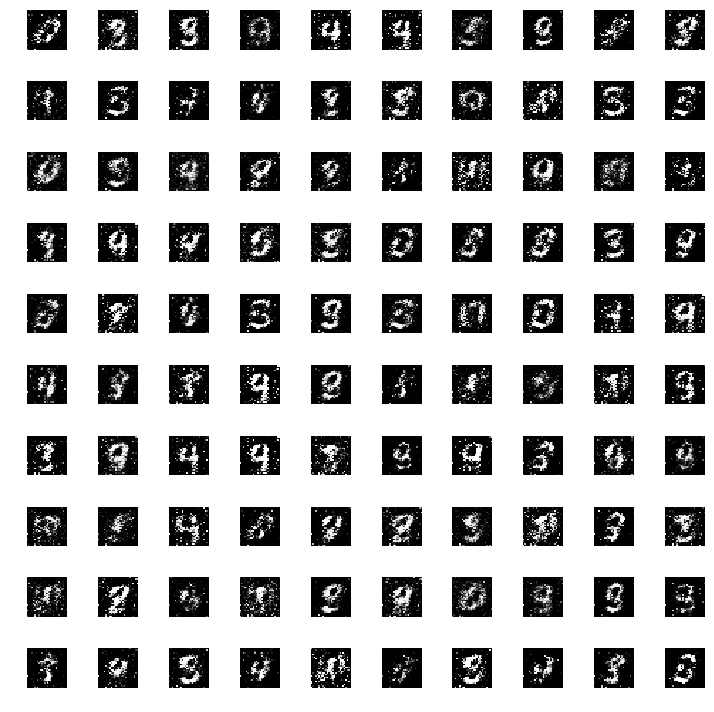

Epoch 6 
Discriminator Loss 186.0137 
Generator loss 1012.0878 
Epoch 7 
Discriminator Loss 193.6944 
Generator loss 944.1502 
Epoch 8 
Discriminator Loss 202.1995 
Generator loss 896.3434 
Epoch 9 
Discriminator Loss 214.1605 
Generator loss 830.9715 
Epoch 10 
Discriminator Loss 224.9461 
Generator loss 791.2959 


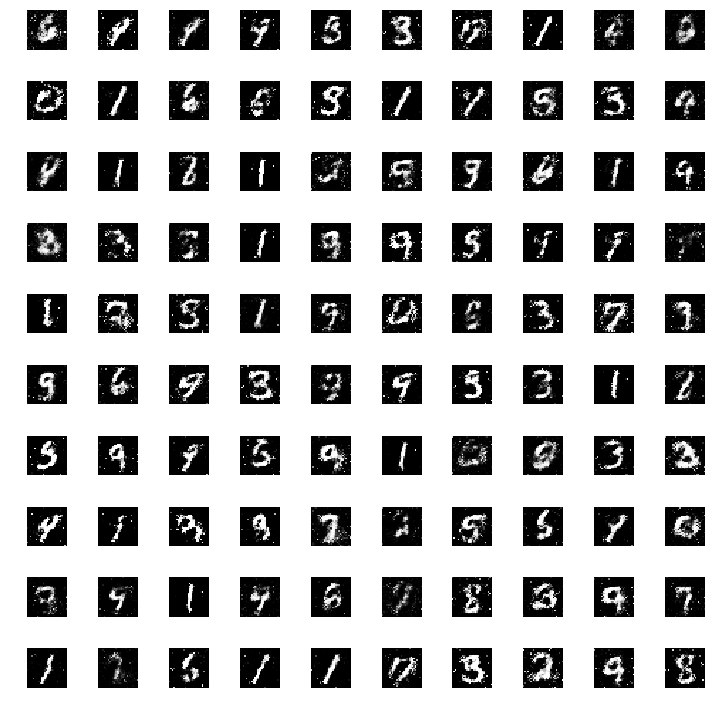

Epoch 11 
Discriminator Loss 230.7169 
Generator loss 760.9943 
Epoch 12 
Discriminator Loss 237.2807 
Generator loss 739.5212 
Epoch 13 
Discriminator Loss 240.5586 
Generator loss 720.2160 
Epoch 14 
Discriminator Loss 242.2401 
Generator loss 715.5078 
Epoch 15 
Discriminator Loss 244.5621 
Generator loss 705.2396 


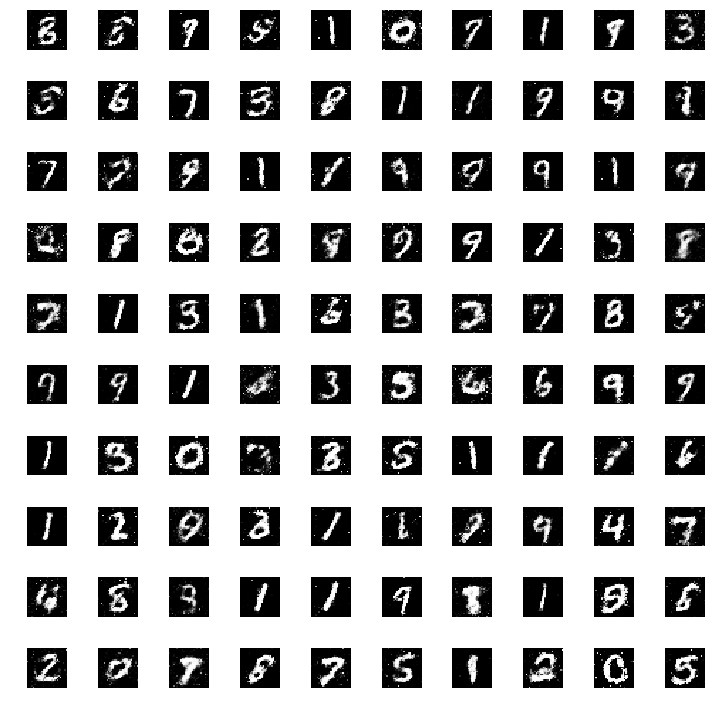

Epoch 16 
Discriminator Loss 245.6610 
Generator loss 707.3754 
Epoch 17 
Discriminator Loss 246.3464 
Generator loss 699.3988 
Epoch 18 
Discriminator Loss 244.0585 
Generator loss 704.9184 
Epoch 19 
Discriminator Loss 245.0588 
Generator loss 717.0547 
Epoch 20 
Discriminator Loss 243.2567 
Generator loss 714.0612 


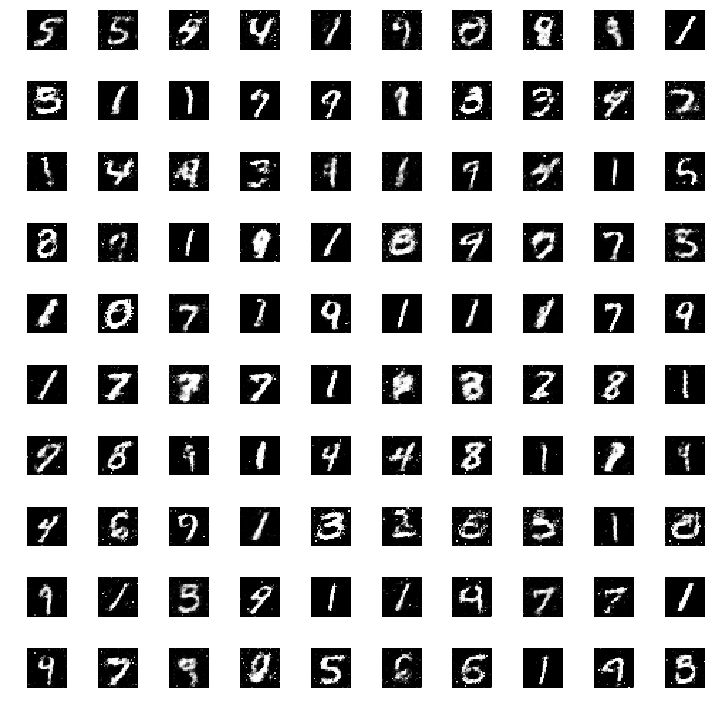

Epoch 21 
Discriminator Loss 243.9125 
Generator loss 720.0350 
Epoch 22 
Discriminator Loss 243.7187 
Generator loss 724.9724 
Epoch 23 
Discriminator Loss 242.6326 
Generator loss 722.4929 
Epoch 24 
Discriminator Loss 242.9861 
Generator loss 728.1777 
Epoch 25 
Discriminator Loss 242.6890 
Generator loss 727.0290 


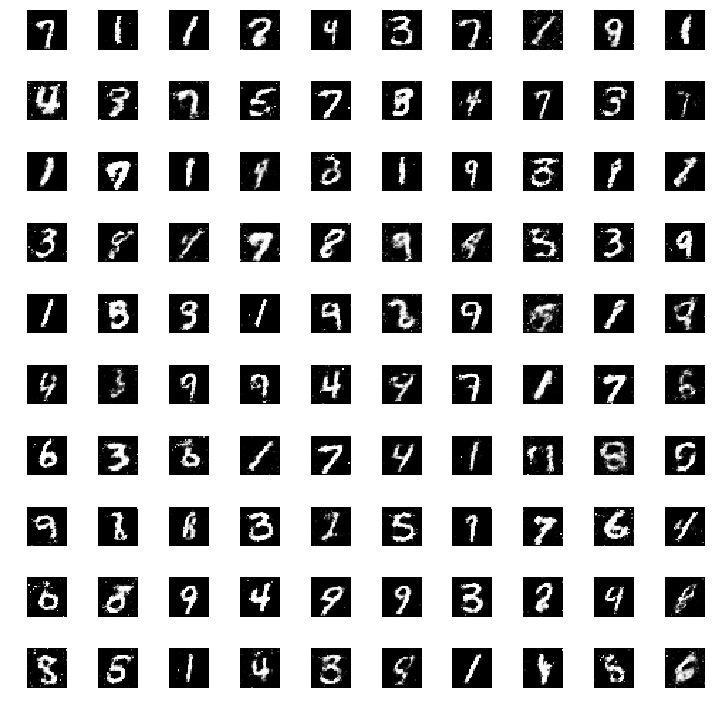

Epoch 26 
Discriminator Loss 242.0405 
Generator loss 728.8846 
Epoch 27 
Discriminator Loss 242.9748 
Generator loss 731.4438 
Epoch 28 
Discriminator Loss 242.0675 
Generator loss 731.5820 
Epoch 29 
Discriminator Loss 241.7831 
Generator loss 730.8116 
Epoch 30 
Discriminator Loss 242.5795 
Generator loss 730.0666 


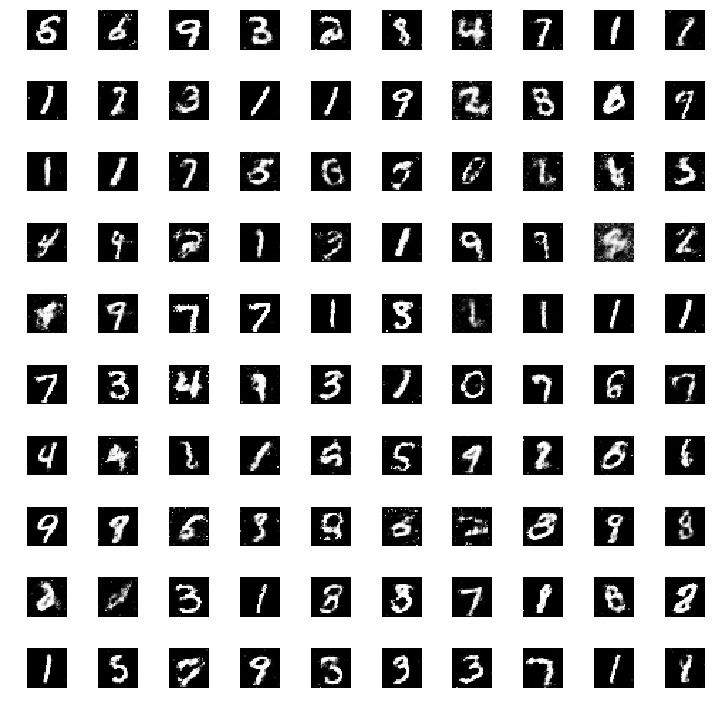

Epoch 31 
Discriminator Loss 242.5472 
Generator loss 731.2253 
Epoch 32 
Discriminator Loss 242.1192 
Generator loss 731.6062 
Epoch 33 
Discriminator Loss 240.8004 
Generator loss 735.6166 
Epoch 34 
Discriminator Loss 242.2085 
Generator loss 732.9515 
Epoch 35 
Discriminator Loss 241.7831 
Generator loss 736.2316 


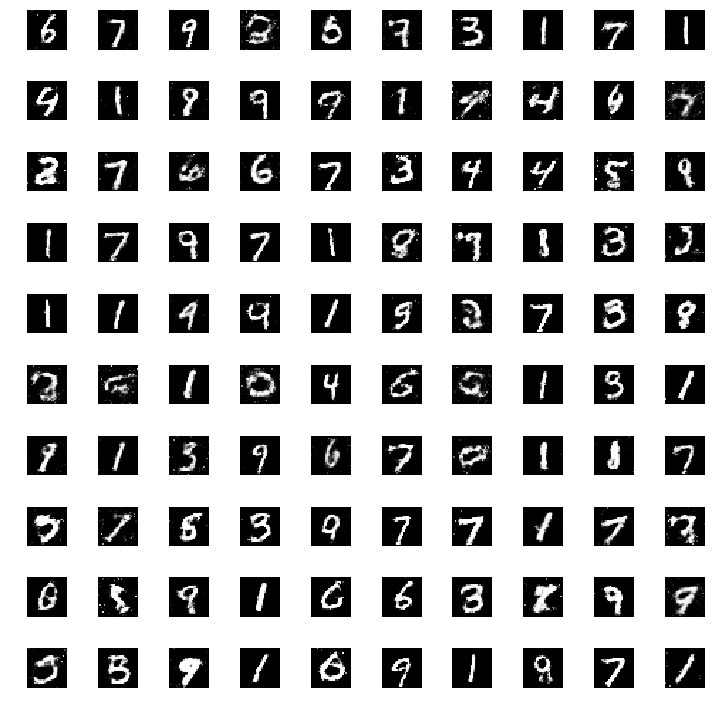

Epoch 36 
Discriminator Loss 241.4071 
Generator loss 735.1830 
Epoch 37 
Discriminator Loss 241.1739 
Generator loss 734.6392 
Epoch 38 
Discriminator Loss 241.1757 
Generator loss 741.5527 
Epoch 39 
Discriminator Loss 242.0387 
Generator loss 741.2392 
Epoch 40 
Discriminator Loss 240.1357 
Generator loss 738.8266 


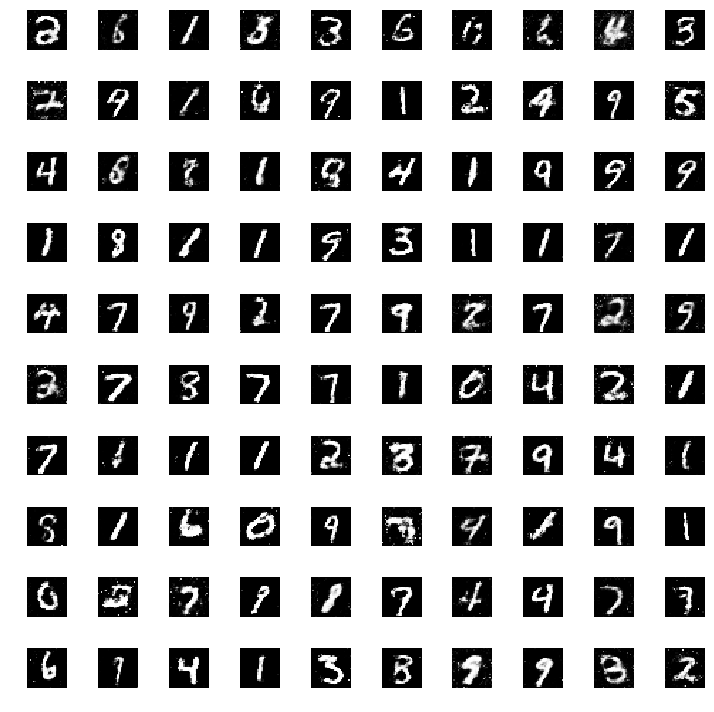

Epoch 41 
Discriminator Loss 241.8047 
Generator loss 734.9991 
Epoch 42 
Discriminator Loss 241.2149 
Generator loss 741.0595 
Epoch 43 
Discriminator Loss 240.3350 
Generator loss 742.5432 
Epoch 44 
Discriminator Loss 240.9413 
Generator loss 743.2646 
Epoch 45 
Discriminator Loss 239.9395 
Generator loss 747.7692 


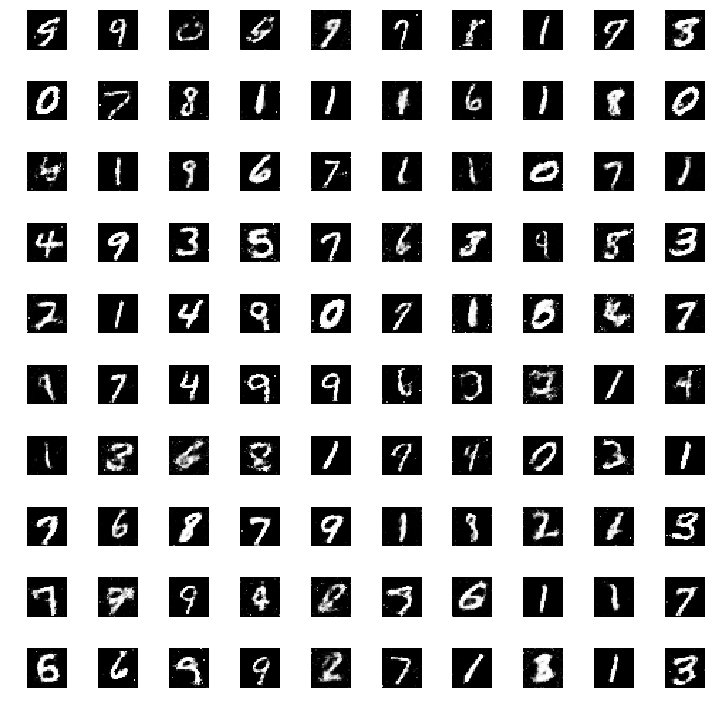

Epoch 46 
Discriminator Loss 240.3146 
Generator loss 741.5171 
Epoch 47 
Discriminator Loss 240.0818 
Generator loss 742.2734 
Epoch 48 
Discriminator Loss 240.0660 
Generator loss 746.9424 
Epoch 49 
Discriminator Loss 240.5385 
Generator loss 747.7392 
Epoch 50 
Discriminator Loss 239.5414 
Generator loss 743.2946 


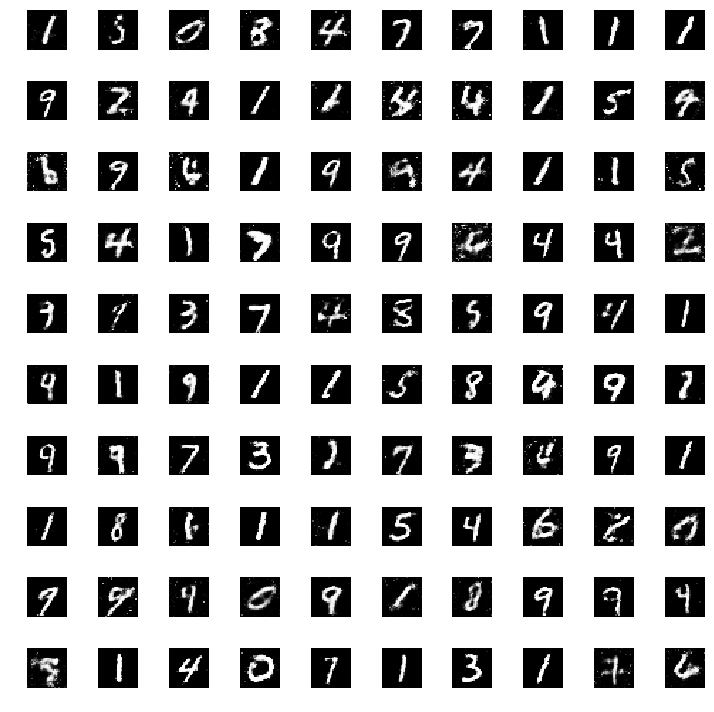

In [19]:
train(50, 128)